## M2 - Model prediksi titik panas di Sumatera Selatan 2001 - 2023

In [1]:
# load all functions
from C01_data_collection import *
from C02_visualization import *
from C03_preprocessing import *
from C04_model_predictions import *
from C05_model_evaluate import *

- config models

In [2]:
# set random number
import random as rm
rm.seed(1234)

# set random number
import numpy as np
np.random.seed(1234)

# set random number
import tensorflow as tf
tf.random.set_seed(1234)

### 1. Data Collections

In [3]:
# load dataset
dataset = data_hotspot("dataset_enso.csv")
print(dataset.tail(3))

      acq_date  hotspot  sst_anom  oni_anom  soi_anom
273 2023-10-31     3200      1.59      1.78      -0.8
274 2023-11-30      390      1.90      1.92      -1.3
275 2023-12-31       42      1.99      1.97      -0.4


### 2. Data Preprocessing

In [4]:
# prosess normalization min-max
scaler, scaled = normalized(dataset, ["hotspot", "sst_anom", "oni_anom", "soi_anom"])

In [5]:
# hasil normalisasi data
np.round(scaled[:3],5)

array([[-1.     , -0.61485, -0.5514 ,  0.36   ],
       [-0.99972, -0.52204, -0.47664,  0.6    ],
       [-0.99903, -0.43387, -0.43925,  0.34   ]])

### 3. Pembagian Data

In [6]:
# proses pembagian data
x_train, y_train, x_test, y_test = results_multivariate_supervised(scaled)

In [7]:
# cek dimensi data
print(x_train.shape, y_train.shape)

(216, 1, 4) (216,)


In [8]:
# cek dimensi data
print(x_test.shape, y_test.shape)

(59, 1, 4) (59,)


In [9]:
# call models LSTM
# param : algorithm, timestep, activation, optimizer, dropout
lstm_model = get_models(
  algorithm="SBi-LSTM", timestep=x_train, activation="relu", optimizer="rmsprop", dropout=0.20
)

In [10]:
# compile models
# param : model, batch_size, epochs, x_train, y_train, x_test, y_test
lstm_history, lstm_predictions = get_prediction(
  model=lstm_model, batch_size=32, epochs=1500, x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test
)

Epoch 1/1500
7/7 [==============================] - 7s 172ms/step - loss: 0.9125 - val_loss: 0.9144
Epoch 2/1500
7/7 [==============================] - 0s 16ms/step - loss: 0.8724 - val_loss: 0.8732
Epoch 3/1500
7/7 [==============================] - 0s 8ms/step - loss: 0.8331 - val_loss: 0.8259
Epoch 4/1500
7/7 [==============================] - 0s 8ms/step - loss: 0.7837 - val_loss: 0.7662
Epoch 5/1500
7/7 [==============================] - 0s 8ms/step - loss: 0.7221 - val_loss: 0.6900
Epoch 6/1500
7/7 [==============================] - 0s 8ms/step - loss: 0.6456 - val_loss: 0.5934
Epoch 7/1500
7/7 [==============================] - 0s 13ms/step - loss: 0.5509 - val_loss: 0.4703
Epoch 8/1500
7/7 [==============================] - 0s 9ms/step - loss: 0.4256 - val_loss: 0.3133
Epoch 9/1500
7/7 [==============================] - 0s 9ms/step - loss: 0.3037 - val_loss: 0.1873
Epoch 10/1500
7/7 [==============================] - 0s 8ms/step - loss: 0.2329 - val_loss: 0.1775
Epoch 11/1500
7

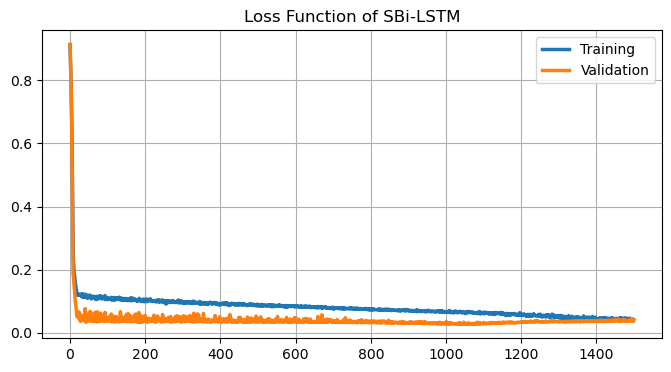

In [11]:
# show loss function
lineplot2(
  x1=lstm_history.epoch, y1=lstm_history.history['loss'], label1="Training",
  x2=lstm_history.epoch, y2=lstm_history.history['val_loss'], label2="Validation",
  title="Loss Function of SBi-LSTM"
)

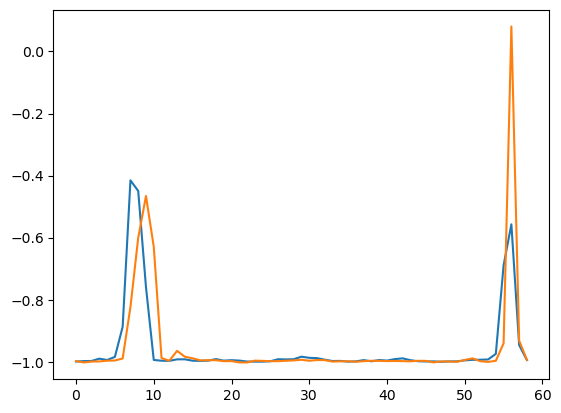

In [15]:
plt.plot(y_test)
plt.plot(lstm_predictions)